In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import networkx as nx
import time
from graph_tool.all import *
import pickle

/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_plann

In [ ]:
from power_planner.utils import angle

In [ ]:
path = "/Users/ninawiedemann/Downloads/tifs_new/tif_layers/Buildingftp.tif"
with rasterio.open(path, 'r') as ds:
    arr = ds.read()[0]

In [ ]:
np.unique(arr)

In [2]:
IOPATH = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_5.dat"
with open(IOPATH, "rb") as infile:
    (instance, instance_corr, start_inds, dest_inds) = pickle.load(infile)

In [ ]:
plt.hist(instance.flatten())
plt.show()

In [ ]:
emerg = np.zeros((20,20))
max_dist = 1.5
for row in np.arange(1,20,max_dist).astype(int):
    emerg[row, np.arange(1,20,max_dist).astype(int)] = 1

### slow version dist arr

In [ ]:
start_inds = np.asarray([163, 24])
dest_inds = np.asarray([94, 240])

In [ ]:
dist_arr = np.zeros(instance.shape)
norm = np.linalg.norm(dest_inds-start_inds)
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        p3 = np.asarray([i,j])
        dist_arr[i,j] = np.abs(np.cross(dest_inds-start_inds, start_inds-p3)) / norm

In [ ]:
plt.imshow(dist_arr)
plt.show()

### fast version for dist arr, but rotation padding problem

In [ ]:
from scipy.ndimage import rotate

In [ ]:
size = np.linalg.norm(dest_inds-start_inds)
size = int(size)
arr = np.zeros((size,size))
arr[:,:size//2] = np.stack([np.arange(size//2) for _ in range(size)])
arr[:,size//2:] = np.vstack([np.arange(size//2,0,-1).tolist() for _ in range(size)])
ang = 90 + 90 * angle([0,1], dest_inds-start_inds)/np.pi
w,h = instance.shape
dist_arr = np.pad(rotate(arr, ang), ((0, w-size), (0,h-size)))

## construct constraint

In [ ]:
start_inds = [163, 24]
dest_inds = [94, 240]
start_dest_inds = np.array([start_inds, dest_inds])
inter_line = start_dest_inds[0]-start_dest_inds[1]
longer = np.argmin(np.abs(inter_line))

padding = [0,0]
percent_padding = 0.25
padding[longer] = abs(int(percent_padding*inter_line[longer]))

start_x, start_y = np.min(start_dest_inds, axis=0) - np.asarray(padding)
end_x, end_y = np.max(start_dest_inds, axis=0) + np.asarray(padding)

corr = np.zeros(instance.shape)
corr[start_x:end_x, start_y:end_y] = 1

In [ ]:
hard_cons = corr * instance_corr # hard_constraints

In [ ]:
max_dist = 10
w_inds = np.arange(start_x, end_x, max_dist).astype(int)
h_inds = np.arange(start_y, end_y, max_dist).astype(int)

# max_cost = np.max(costs)
for row in w_inds:
    hard_cons[row, h_inds] = 1
    # costs[row, h_inds] = max_cost


In [ ]:
padding

In [ ]:
start_x, start_y

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(hard_cons) # possible)
plt.show()

## Test algorithms on instance

In [ ]:
INP = "/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/path_70055.weighted.edgelist"

In [ ]:
g = nx.read_edgelist(
                INP,
                nodetype=float,
                create_using=nx.DiGraph,
                data=(('weight', float), )
            )

In [ ]:
vec = np.linalg.norm([-173, 539])

In [ ]:
cutoff = 4*vec/15
cutoff

In [ ]:
class SP():
    def __init__(self, graph):
        self.graph = graph

    def bellman_ford_my(self, source, target, cutoff):
        """
        Actual BF algorithm, not SPFA
        """
        pred = {}
        dist = {source: 0}

        inf = float('inf')

        for i in range(int(cutoff)):
            print(i)
            for (u, v, w_dict) in self.graph.edges(data=True):
                w = w_dict["weight"]
                if dist.get(u, inf) + w < dist.get(v, inf):
                    dist[v] = dist[u] + w
                    pred[v] = u
        path = [target]
        curr = target
        while curr != source:
            curr = pred[curr]
            path.append(curr)
        path.append(source)
        return list(reversed(path))

    def bellman_ford_nx(
        self,
        source,
        target,
        pred=None,
        paths=None,
        dist=None,
    ):
        """Relaxation loop for Bellman–Ford algorithm.
        This is an implementation of the SPFA variant.
        See https://en.wikipedia.org/wiki/Shortest_Path_Faster_Algorithm
        Parameters
        SEE https://github.com/networkx/networkx/blob/02a1721276b3a84d3be8558e4
        79a9cb6b0715488/networkx/algorithms/shortest_paths/weighted.py#L1203
        """
        G = self.graph
        weight = lambda u, v, data: data.get("weight", 1)
 
        # vertices_path = self.bellman_ford(source, target, cutoff)
        paths = {source: [source]}
        # dist, it_list = self._bellman_ford(self.graph, [source], weight, cutoff, paths = paths, target=target)
        # vertices_path = paths[target]
        source = [source]
        
        for s in source:
            if s not in G:
                raise nx.NodeNotFound(f"Source {s} not in G")

        if pred is None:
            pred = {v: [] for v in source}

        if dist is None:
            dist = {v: 0 for v in source}

        G_succ = G.succ if G.is_directed() else G.adj
        print("directed?", G.is_directed())
        inf = float('inf')
        n = len(G)

        # count = {}
        q = deque(source)
        in_q = set(source)
        iteration = 0
        it_list = []
        while q:
            u = q.popleft()
            in_q.remove(u)
            
            it_ind = 0
            
            # print("new vertex", u)

            # Skip relaxations if any of the predecessors of u is in the queue.
            if all(pred_u not in in_q for pred_u in pred[u]):
                dist_u = dist[u]
                # print(dist_u)
                for v, e in G_succ[u].items():
                    dist_v = dist_u + weight(u, v, e)  # TODO:replace function
                    # print(v)
                    if dist_v < dist.get(v, inf):
                        
                        if v not in in_q:
                            # print("update")
                            q.append(v)
                            in_q.add(v)
                            # count_v = count.get(v, 0) + 1
                            # if count_v == n:
                            #     raise nx.NetworkXUnbounded(
                            #         "Negative cost cycle detected."
                            #     )
                            # count[v] = count_v
                        dist[v] = dist_v
                        pred[v] = [u]

                    elif dist.get(v) is not None and dist_v == dist.get(v):
                        pred[v].append(u)
                    
                    it_ind += 1
            else:
                # pass
                print("err")
            
            it_list.append(it_ind)
            iteration += 1

            # TODO
            # if u == target:
            #     print("early stopping")
            #     break
            # if iteration > cutoff and dist.get(target, inf) < inf:
                # print("iteration more than cutoff")
                # if dist.get(target, inf) < inf:
                # print("early stopping")
                # break
        print("number of iterations:", iteration)
        if paths is not None:
            dsts = [target] if target is not None else pred
            for dst in dsts:

                path = [dst]
                cur = dst

                while pred[cur]:
                    cur = pred[cur][0]
                    path.append(cur)

                path.reverse()
                paths[dst] = path

        return paths[target], it_list # dist, it_list
from collections import deque


In [ ]:
g_undir = g.to_undirected()

In [ ]:
print("Start shortest path")
sp = SP(g)
out = sp.bellman_ford_nx(43104, 8447) # , it_list

## Test results:

* graph with 5.6 mio edges, 50 000 nodes
* directed case: 50757 terations, so slightly more than the nodes --> doch cycles --> maybe because of 180 degrees thing? (15 sec)
* undirected case: 59042 iterations why not more? though more iterations in each iteration probably, takes longer (26 sec)


* my algorithm: 10 minutes! (for 150 iterations) --> basically 150 times the runtime of the other ones
* with directed edges, other algorithm: 5 837 055, but just twice the time 12 753 072 if undirected


* because of Skip relaxations if any of the predecessors of u is in the queue?

sanity check was correct: inner iteration (over neighbors) is twice as much for undirected as for directed

In [ ]:
len(g.edges)

In [ ]:
len(g.nodes)

### total iterations for directed / undirected:

In [ ]:
print(50757*115, 59042*216)

### Sanity check

In [ ]:
np.mean(it_list)

In [ ]:
plt.hist(it_list)
plt.show()

In [ ]:
np.mean(it_list)

In [ ]:
plt.hist(it_list)
plt.show()

## Random graph tests

In [ ]:
comp = nx.complete_graph(100)

In [ ]:
len(comp.edges())

In [ ]:
sp = SP(comp)
out, its = sp.bellman_ford_nx(0, 5) # , it_list

In [ ]:
sum(its)

In [ ]:
g_new = nx.DiGraph()
e = []
# for i in range(20):
#    e.append([i,i+1,{"weight":i}])
for i in range(1,4):
    e.append([0,i,{"weight":i}])
for i in range(1,4):
    e.append([i,5, {"weight":i}])
g_new.add_edges_from(e)

In [ ]:
sp = SP(g_new)
out = sp.get_shortest_path_nx(0, 5) # , it_list

In [ ]:
nx.write_weighted_edgelist(
                g_new,'test.weighted.edgelist'
            )

In [ ]:
in_g_new = nx.read_edgelist(
                'test.weighted.edgelist',
                nodetype=int,
    create_using=nx.DiGraph,
                data=(('weight', float), )
            )

In [ ]:
in_g_new_dir = nx.DiGraph(in_g_new)

In [ ]:
in_g_new.out_edges()

In [ ]:
g_new.edges()

In [ ]:
len(comp.nodes()), len(comp.edges())

In [ ]:
g1 = Graph()
g1.add_vertex(20)
g1.add_edge_list([[i,i+1] for i in range(19)])

In [ ]:
len(list(g1.vertices())), len(list(g1.edges()))

In [ ]:
len(list(comp.nodes())), len(list(comp.edges()))

## subplots for paths

In [ ]:
a = np.zeros((500,1000))
a[200:260, 100:500] = np.arange(24000).reshape(60,400)
a = np.swapaxes(a,1,0)

In [ ]:
b = a[:, np.any(a>0, axis=0)]
b = b[np.any(b>0, axis=1), :]

In [ ]:
b = np.arange(20).reshape(2,10)
b.shape

In [ ]:
x

In [ ]:
plt.figure(figsize=(25,15))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(b)
    plt.axis('scaled')
plt.tight_layout()
plt.show()

## Summarize points

In [3]:
inst = instance*instance_corr
test = inst[:, np.any(inst > 0, axis=0)]
test = test[np.any(test > 0, axis=1), :]

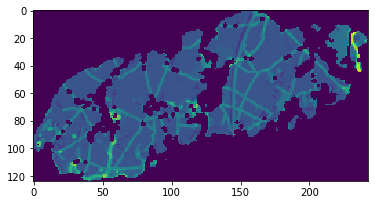

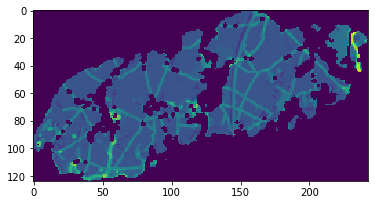

In [4]:
plt.imshow(test)
plt.show()